In [ ]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [ ]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('/content/ETH-USD.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df1 = df['Close']

In [ ]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [ ]:
# 4. Hàm tạo dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)


In [ ]:
# 5. Hàm huấn luyện mô hình
def train_model(train_data, time_step=100, epochs=50, batch_size=32):
    X_train, y_train = create_dataset(train_data, time_step)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

    model = Sequential()
    model.add(GRU(64, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)
    return model


In [ ]:
# 6. Hàm đánh giá mô hình
def evaluate_model(model, test_data, time_step=100):
    X_test, y_test = create_dataset(test_data, time_step)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    y_pred = model.predict(X_test)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred = scaler.inverse_transform(y_pred)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print('MSE:', mse)
    print('MAE:', mae)
    print('RMSE:', rmse)
    print('MAPE:', mape)
    return y_test, y_pred

In [ ]:
# 7. Hàm dự báo
def forecast(model, input_data, steps, time_step=100):
    temp_input = list(input_data.flatten())
    lst_output = []
    i = 0
    while i < steps:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
        else:
            x_input = np.array(temp_input).reshape((1, len(temp_input), 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.append(yhat[0, 0])
        lst_output.append(yhat[0, 0])
        i += 1
    return scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))

In [ ]:
# 8. Chia tập dữ liệu và huấn luyện mô hình với các tỷ lệ train-test khác nhau
train_test_ratios = [0.6, 0.7, 0.8]
time_step = 100

forecasts = {}
for ratio in train_test_ratios:
    train_size = int(ratio * len(df1))
    train_data = df1[:train_size]
    test_data = df1[train_size:]

    model = train_model(train_data, time_step)
    y_test, y_pred = evaluate_model(model, test_data, time_step)

    forecast_90 = forecast(model, test_data[-time_step:], 90, time_step)
    forecasts[ratio] = forecast_90

Epoch 1/50
38/38 - 5s - loss: 0.0162 - 5s/epoch - 120ms/step
Epoch 2/50
38/38 - 1s - loss: 7.4297e-04 - 1s/epoch - 35ms/step
Epoch 3/50
38/38 - 1s - loss: 4.3695e-04 - 1s/epoch - 35ms/step
Epoch 4/50
38/38 - 1s - loss: 4.0922e-04 - 1s/epoch - 35ms/step
Epoch 5/50
38/38 - 1s - loss: 3.9957e-04 - 1s/epoch - 35ms/step
Epoch 6/50
38/38 - 1s - loss: 3.5076e-04 - 1s/epoch - 35ms/step
Epoch 7/50
38/38 - 1s - loss: 3.1988e-04 - 1s/epoch - 35ms/step
Epoch 8/50
38/38 - 2s - loss: 3.2242e-04 - 2s/epoch - 43ms/step
Epoch 9/50
38/38 - 2s - loss: 2.9270e-04 - 2s/epoch - 60ms/step
Epoch 10/50
38/38 - 2s - loss: 2.9359e-04 - 2s/epoch - 45ms/step
Epoch 11/50
38/38 - 1s - loss: 2.9081e-04 - 1s/epoch - 36ms/step
Epoch 12/50
38/38 - 1s - loss: 2.8731e-04 - 1s/epoch - 35ms/step
Epoch 13/50
38/38 - 1s - loss: 2.6208e-04 - 1s/epoch - 35ms/step
Epoch 14/50
38/38 - 1s - loss: 2.6173e-04 - 1s/epoch - 35ms/step
Epoch 15/50
38/38 - 1s - loss: 2.4667e-04 - 1s/epoch - 35ms/step
Epoch 16/50
38/38 - 1s - loss: 2.6496

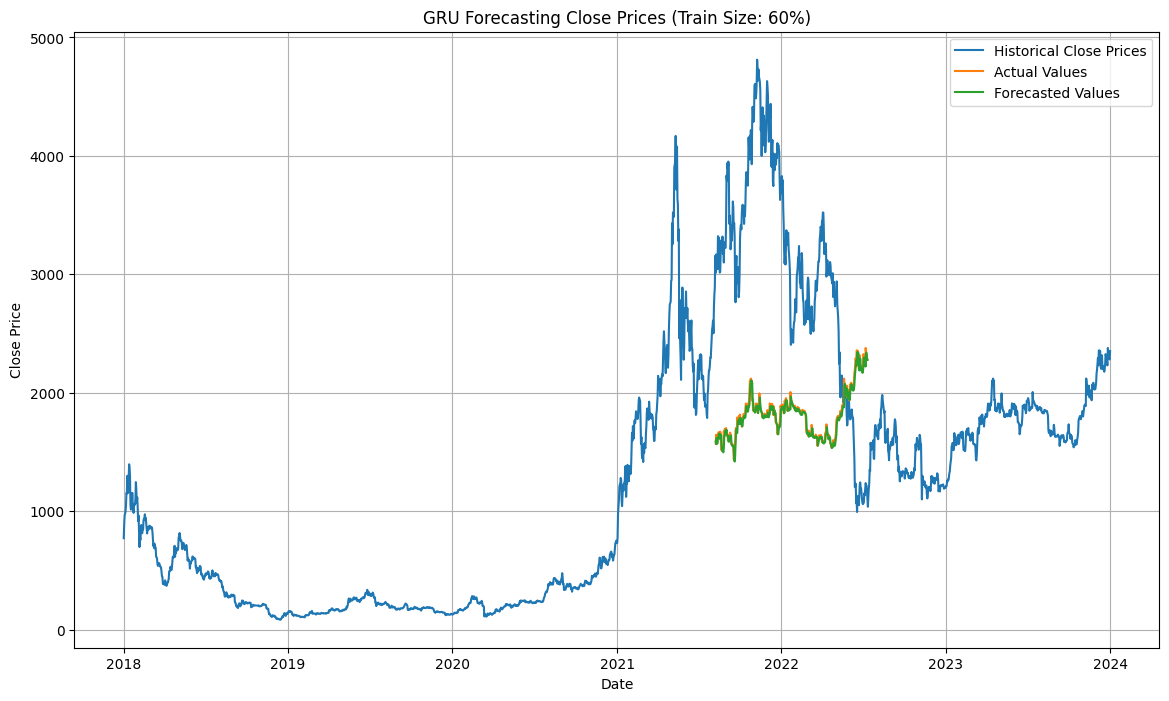

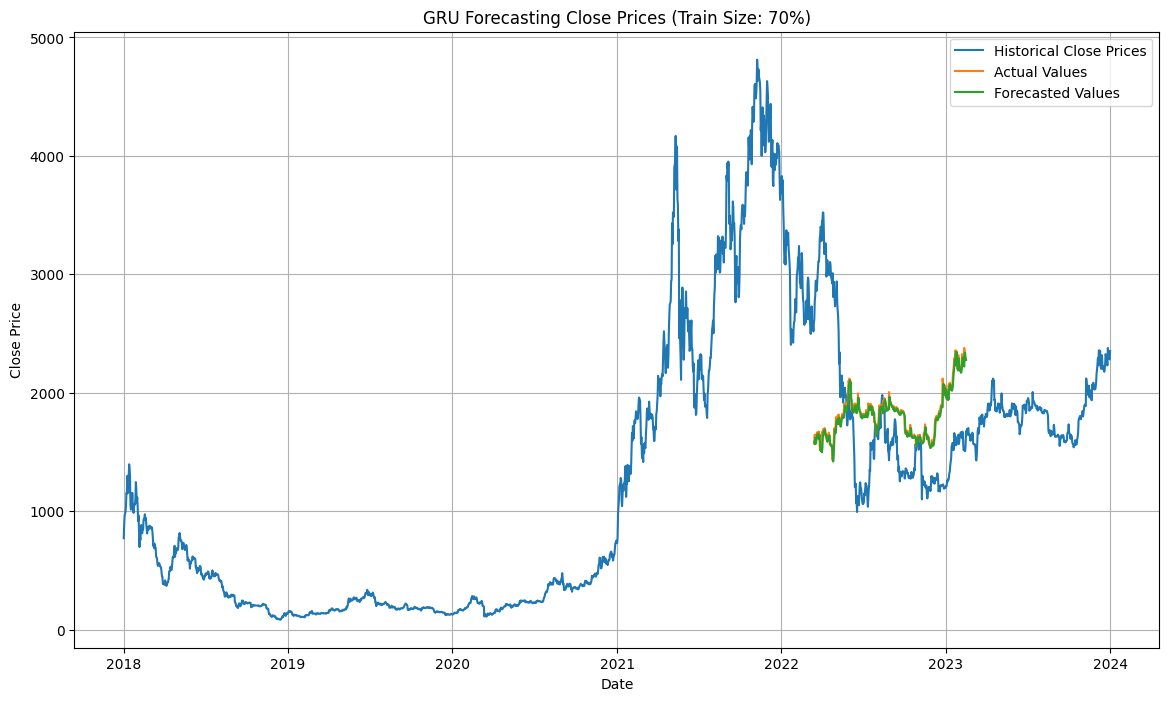

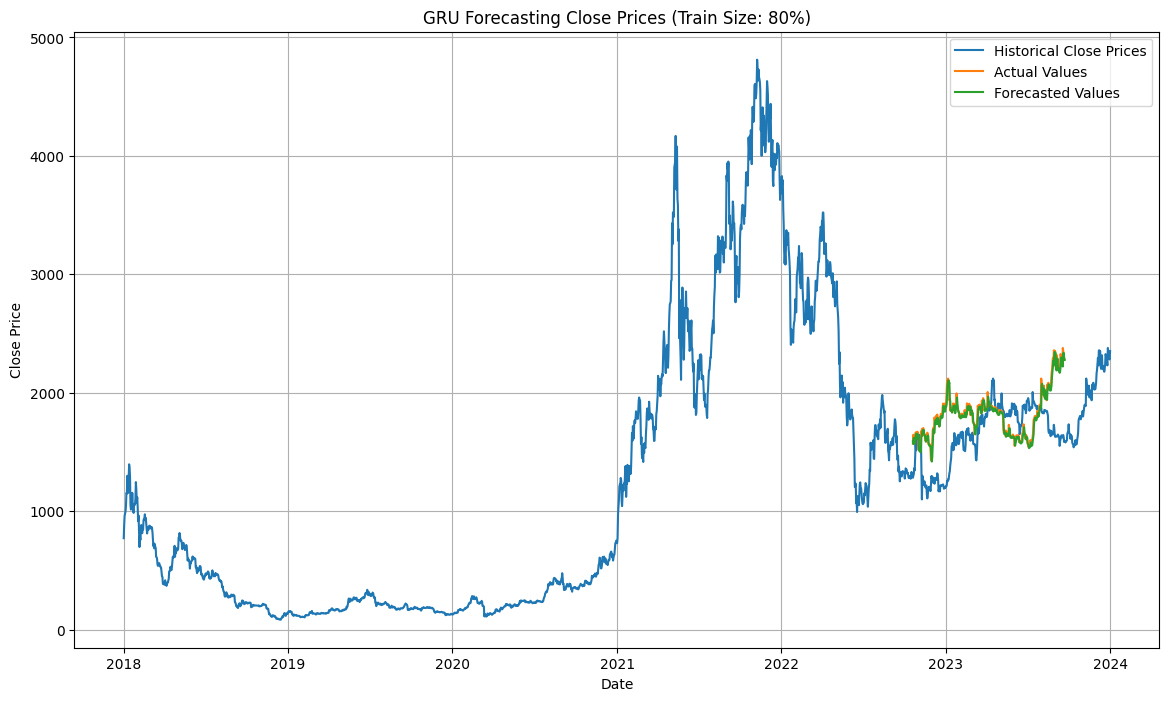

In [ ]:
import matplotlib.pyplot as plt

def plot_forecast(ratio, df, scaler, df1, y_test, y_pred, train_size):
    plt.figure(figsize=(14, 8))
    plt.plot(df.index, scaler.inverse_transform(df1), label='Historical Close Prices')
    plt.plot(df.index[train_size:train_size + len(y_test)], y_test, label='Actual Values')
    plt.plot(df.index[train_size:train_size + len(y_pred)], y_pred, label='Forecasted Values')
    plt.title(f'GRU Forecasting Close Prices (Train Size: {int(ratio * 100)}%)')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Tỷ lệ tập huấn luyện khác nhau
ratios = [0.6, 0.7, 0.8]

# Vòng lặp qua các tỷ lệ để tạo mô hình và vẽ biểu đồ
for ratio in ratios:
    train_size = int(len(df) * ratio)

    # Chuẩn bị dữ liệu cho tỷ lệ hiện tại
    train_data = df[:train_size]
    test_data = df[train_size:]

    # Chuẩn hóa dữ liệu nếu cần
    # scaled_train_data = scaler.transform(train_data)
    # scaled_test_data = scaler.transform(test_data)

    # Tạo và huấn luyện mô hình
    # model = create_and_train_model(scaled_train_data)

    # Dự đoán trên tập test
    # y_pred = model.predict(scaled_test_data)

    # Đảo ngược chuẩn hóa nếu cần
    # y_test = scaler.inverse_transform(test_data)
    # y_pred = scaler.inverse_transform(y_pred)

    # Vẽ biểu đồ cho tỷ lệ hiện tại
    plot_forecast(ratio, df, scaler, df1, y_test, y_pred, train_size)


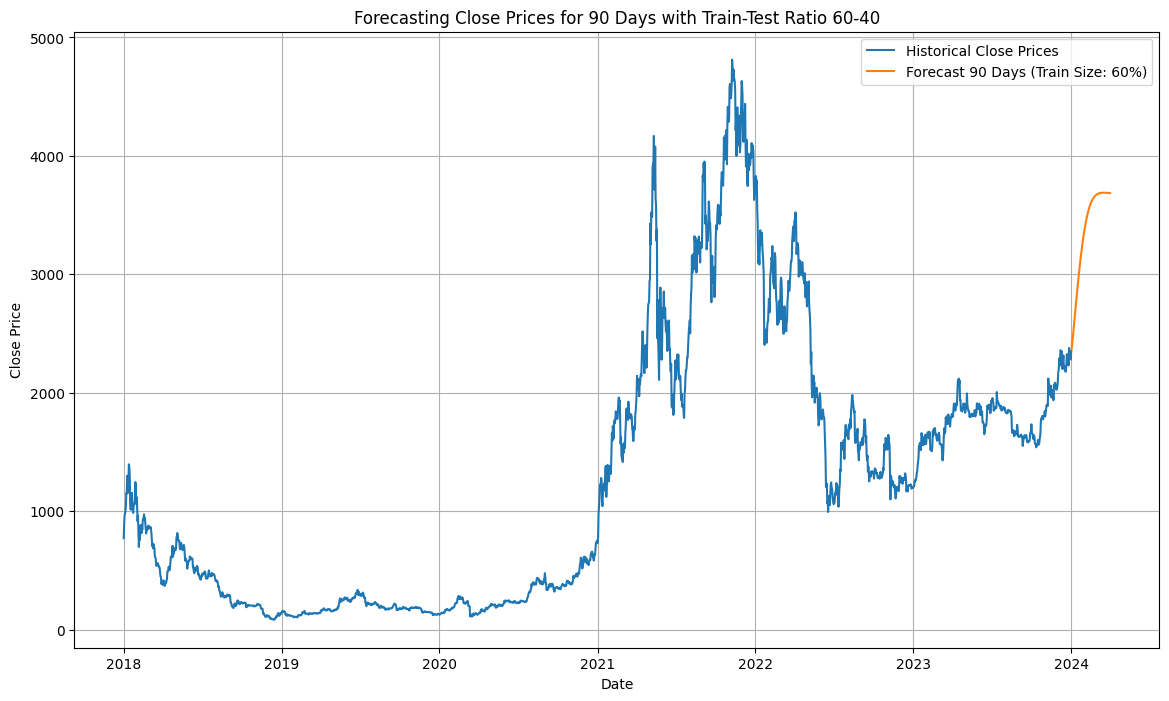

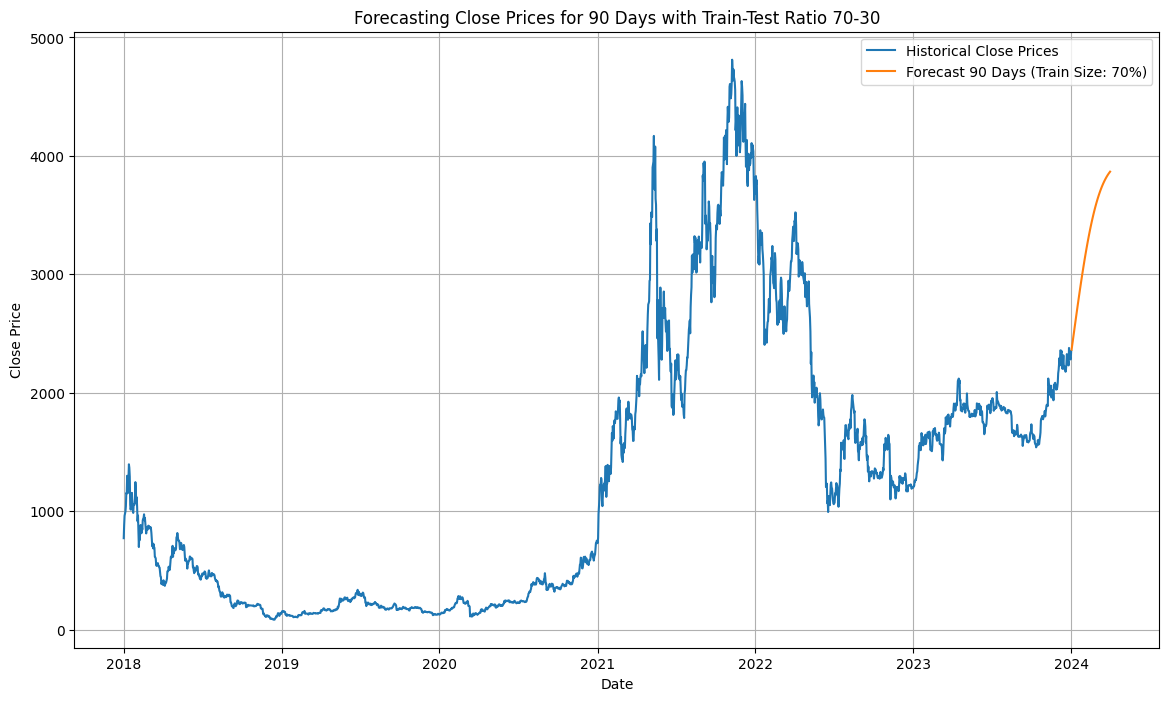

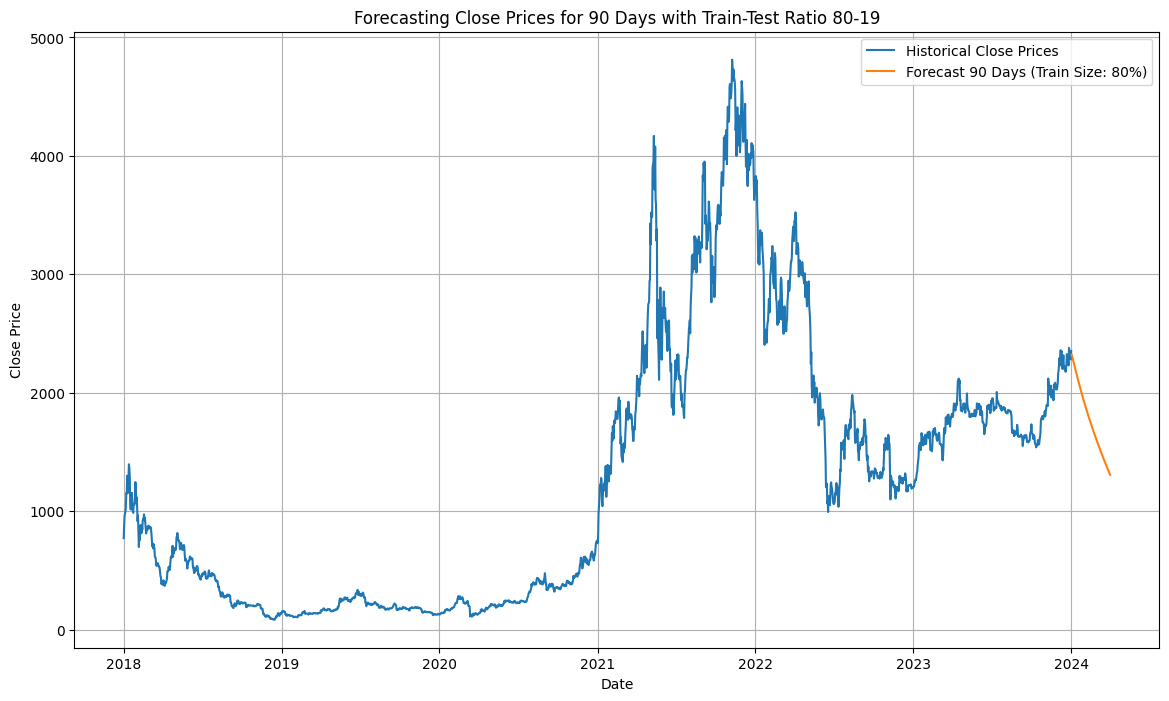

In [ ]:
# 9. Vẽ biểu đồ dự báo 90 ngày cho các tỷ lệ train-test riêng biệt
for ratio, forecast_90 in forecasts.items():
    future_dates = pd.date_range(df.index[-1] + pd.DateOffset(1), periods=90, freq='D')

    plt.figure(figsize=(14, 8))
    plt.plot(df.index, scaler.inverse_transform(df1), label='Historical Close Prices')
    plt.plot(future_dates, forecast_90, label=f'Forecast 90 Days (Train Size: {int(ratio * 100)}%)')

    plt.title(f'Forecasting Close Prices for 90 Days with Train-Test Ratio {int(ratio * 100)}-{int((1-ratio) * 100)}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()